### Configuração do ambiente

##### 1. Configurando o google colab

In [40]:
import skfuzzy as fuzz
print("✅ Scikit-fuzzy instalado com sucesso!")

✅ Scikit-fuzzy instalado com sucesso!


##### 2. Conectando com Kaggle

In [41]:
%pip install networkx

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
import json
import os

# Ler o JSON normalmente
with open('../kaggle/kaggle.json', 'r') as file:
    kaggle_credentials = json.load(file)

# Criar a pasta .kaggle no diretório do usuário TEMPORARIAMENTE
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)

# Salvar o JSON lá
with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as file:
    json.dump(kaggle_credentials, file)

print("Kaggle configurado!")


Kaggle configurado!


### Contextualização

In [43]:
# "Imaginem que vocês são sommeliers digitais. Como um especialista
# em vinhos decide a qualidade? É só química ou há algo mais sutil?"

### Visualizando o dataset com pandas

In [44]:
import pandas as pd

# Caminho do dataset
path = '../datasets/wine_quality.csv'

# Lendo o CSV
wine_data = pd.read_csv(path)

# Exibir as 5 primeiras linhas (visual bonito no notebook)
wine_data.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


### Colunas do dataset

In [45]:
# | Coluna                 | Significado                                                                  |
# | ---------------------- | ---------------------------------------------------------------------------- |
# | `fixed acidity`        | Ácido fixo (ex: tartárico)                                                   |
# | `volatile acidity`     | Ácido volátil (ex: acético, vinagre)                                         |
# | `citric acid`          | Acidez cítrica (mais frescor)                                                |
# | `residual sugar`       | Açúcar residual (doçura)                                                     |
# | `chlorides`            | Quantidade de sal (cloreto de sódio)                                         |
# | `free sulfur dioxide`  | Conservante livre (evita oxidação)                                           |
# | `total sulfur dioxide` | Conservante total (livre + combinado)                                        |
# | `density`              | Densidade do vinho                                                           |
# | `pH`                   | Acidez global                                                                |
# | `sulphates`            | Intensificador de sabor e antimicrobiano                                     |
# | `alcohol`              | Teor alcoólico (%)                                                           |
# | `quality`              | Nota de qualidade (0 a 10 ou 0 a 8)                                          |
# | `Id`                   | Provavelmente um identificador artificial (não influencia a qualidade em si) |


### Análise Exploratória

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import random

class SommelierFuzzy:
    def __init__(self, path="../datasets/wine_quality.csv"):
        # Caminho do dataset
        self.path = path
        self.dataset = None
        self.simulador = None
        self.current_region = None

        # Variáveis de entrada e saída
        self.variaveis_entrada = [
            "fixed acidity", "volatile acidity", "citric acid",
            "residual sugar", "chlorides", "free sulfur dioxide",
            "total sulfur dioxide", "density", "pH",
            "sulphates", "alcohol"
        ]
        self.variavel_saida = "quality"

    def carregar_dataset(self):
        """Carrega o dataset usando pandas"""
        self.dataset = pd.read_csv(self.path)

        # Remove coluna 'Id' se existir
        if 'Id' in self.dataset.columns:
            self.dataset = self.dataset.drop(columns=["Id"])

        return self.dataset

    def analise_exploratoria(self):
        """Mostra estatísticas e gráficos"""
        if self.dataset is None:
            print("Dataset não carregado. Use carregar_dataset() antes.")
            return

        print("Estatísticas básicas:")
        display(self.dataset.describe())

        print("\nCorrelação com 'quality':")
        display(self.dataset.corr(numeric_only=True)["quality"].sort_values(ascending=False))

        # Gráfico de correlação
        plt.figure(figsize=(12, 8))
        sns.heatmap(self.dataset.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
        plt.title("Mapa de Correlação")
        plt.show()

    def construir_sistema_fuzzy(self, region="geral"):

        """
        Constrói o sistema fuzzy com regras específicas por região.
        region: 'geral', 'porto', 'bordeaux', etc.
        """
        self.current_region = region

        # VARIÁVEIS DE ENTRADA
        alcool = ctrl.Antecedent(np.arange(8, 15, 0.1), 'alcool')
        sulphates = ctrl.Antecedent(np.arange(0, 2, 0.1), 'sulphates')
        vol_acidity = ctrl.Antecedent(np.arange(0, 1.5, 0.05), 'volatile_acidity')

        # Nova variável de entrada "originalidade"
        # originalidade = ctrl.Antecedent(np.arange(0, 10, 0.1), 'originalidade')

        # VARIÁVEL DE SAÍDA
        qualidade = ctrl.Consequent(np.arange(0, 11, 1), 'qualidade')

        # FUNÇÕES DE PERTINÊNCIA
        # Funções para as variáveis existentes (álcool, sulphates, vol_acidity) - usando os valores modificados para o sistema mais rigoroso
        alcool['baixo'] = fuzz.trimf(alcool.universe, [8, 8, 10])
        alcool['medio'] = fuzz.trimf(alcool.universe, [9.5, 11.5, 13])
        alcool['alto'] = fuzz.trimf(alcool.universe, [13, 14, 14])

        sulphates['baixo'] = fuzz.trimf(sulphates.universe, [0, 0, 0.6])
        sulphates['medio'] = fuzz.trimf(sulphates.universe, [0.4, 0.8, 1.2])
        sulphates['alto'] = fuzz.trimf(sulphates.universe, [1.2, 2.0, 2.0])

        vol_acidity['baixo'] = fuzz.trimf(vol_acidity.universe, [0, 0, 0.4])
        vol_acidity['medio'] = fuzz.trimf(vol_acidity.universe, [0.3, 0.6, 0.9])
        vol_acidity['alto'] = fuzz.trimf(vol_acidity.universe, [0.8, 1.5, 1.5])

        # Funções de pertinência para "originalidade" (baseadas na sua interpretação de "açúcar e acidez")
        # Exemplo: Uma combinação de açúcar e acidez incomum pode ser considerada "original".
        # Precisamos definir como a "originalidade" é calculada a partir de "residual sugar" e "fixed acidity".
        # Para simplificar neste exemplo, vamos criar funções baseadas em um valor calculado de originalidade.
        # Você pode criar uma métrica simples como a diferença absoluta entre eles ou uma combinação ponderada.
        # Por enquanto, vamos definir as funções de pertinência para a variável "originalidade" diretamente.

        # originalidade['comum'] = fuzz.trimf(originalidade.universe, [0, 0, 5])
        # originalidade['interessante'] = fuzz.trimf(originalidade.universe, [3, 6, 9])
        # originalidade['singular'] = fuzz.trimf(originalidade.universe, [7, 10, 10])

        # FUNÇÕES DE PERTINÊNCIA PARA A VARIÁVEL DE SAÍDA
        qualidade['ruim'] = fuzz.trimf(qualidade.universe, [0, 0, 5])
        qualidade['media'] = fuzz.trimf(qualidade.universe, [4, 5.5, 7])
        qualidade['boa'] = fuzz.trimf(qualidade.universe, [7, 10, 10])

        # REGRAS FUZZY
        regras = [
            ctrl.Rule(alcool['alto'] & sulphates['alto'] & vol_acidity['baixo'], qualidade['boa']),
            ctrl.Rule(alcool['medio'] & sulphates['medio'], qualidade['media']),
            ctrl.Rule(alcool['baixo'] | vol_acidity['alto'], qualidade['ruim']),
            ctrl.Rule(sulphates['baixo'] & vol_acidity['alto'], qualidade['ruim']),
            ctrl.Rule(alcool['alto'] & vol_acidity['medio'], qualidade['media']),
        ]


        # SISTEMA E SIMULADOR
        sistema_ctrl = ctrl.ControlSystem(regras)
        self.simulador = ctrl.ControlSystemSimulation(sistema_ctrl)

        print("Sistema fuzzy construído com 4 entradas e 1 saída (incluindo originalidade).")

    # def avaliar_vinho(self, alcool_val, sulphates_val, vol_acidity_val):
    #     """Faz a simulação fuzzy com os valores passados"""
    #     self.simulador.input['alcool'] = alcool_val
    #     self.simulador.input['sulphates'] = sulphates_val
    #     self.simulador.input['volatile_acidity'] = vol_acidity_val
    #     # self.simulador.input['originalidade'] = originalidade_val # Adicionar a nova entrada

    #     self.simulador.compute()
    #     resultado = self.simulador.output['qualidade']
    #     print(f"Resultado fuzzy: qualidade = {resultado:.2f}")
    
    import random

    def avaliar_por_correlacao(self, alcool, sulphates, volatile_acidity):
        nota = 0

        # Álcool influencia muito positivamente (+0.48)
        if alcool >= 12:
            nota += 2
        elif alcool >= 11:
            nota += 1
        else:
            nota -= 1  # baixo álcool, puxa pra baixo

        # Sulphates influencia positivamente, mas pouco (+0.26)
        if sulphates >= 0.9:
            nota += 1
        elif sulphates < 0.6:
            nota -= 0.5

        # Acidez volátil é vilã (-0.41)
        if volatile_acidity >= 0.6:
            nota -= 2
        elif volatile_acidity >= 0.4:
            nota -= 1

        # Respostas possíveis
        respostas_boa = [
            "🍷 Este vinho promete! Teor alcoólico elevado, bom nível de sulphates e baixa acidez volátil. Tá digno de uma celebração.",
            "✨ Corpo, estrutura e equilíbrio. Esse vinho não veio pra brincadeira. Prepare a taça boa, porque é qualidade garantida!",
            "🔥 Intenso e elegante. Alto teor alcoólico, bem balanceado. Uma experiência que vale cada gole.",
            "🍇 Complexo, sedutor, com aquele final longo que faz qualquer enólogo abrir um sorriso.",
            "🥂 Este é daqueles que você leva pra impressionar. Potente, bem construído, e que entrega tudo no paladar."
        ]

        respostas_media = [
            "🍷 Um vinho honesto. Dá conta do recado, mas não espere fogos de artifício. Bom pra um almoço ou rolê descontraído.",
            "🫥 Tá ok... Nem lá, nem cá. Cumpre o papel, mas não vai virar lenda na sua adega.",
            "🤔 Um vinho que se equilibra no quase. Tem virtudes, mas também tropeços. Vai depender da sua generosidade na avaliação.",
            "🥴 Ele tenta... e até entrega algo. Serve pra acompanhar uma pizza ou uma conversa sem muita pretensão.",
            "👌 Dá pra encarar. Não é dos piores, nem dos melhores. Tá no meio do caminho, como aquele crush que não te responde."
        ]

        respostas_ruim = [
            "🚨 Rapaz... esse aqui tá pedindo socorro. Álcool baixo, acidez gritando, falta tudo que se espera de um vinho digno.",
            "❌ Foge que é cilada. Esse vinho tem todos os alertas de baixa qualidade. Melhor nem abrir.",
            "🤢 Ácido demais, fraco no álcool, e nem sulphates salvam. Provavelmente vai te fazer questionar suas escolhas.",
            "🫠 Parece suco... mas não dos bons. Melhor deixar esse na prateleira e fingir que não viu.",
            "💀 Se qualidade tivesse fundo do poço, esse tava cavando mais. Procura outro, sério."
        ]

        # Seleção da resposta
        if nota >= 2:
            return random.choice(respostas_boa)
        elif nota >= 0:
            return random.choice(respostas_media)
        else:
            return random.choice(respostas_ruim)



🔍 MISSÃO: Descubram padrões interessantes!
Estatísticas básicas:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000



Correlação com 'quality':


quality                 1.000000
alcohol                 0.484866
sulphates               0.257710
citric acid             0.240821
fixed acidity           0.121970
residual sugar          0.022002
pH                     -0.052453
free sulfur dioxide    -0.063260
chlorides              -0.124085
density                -0.175208
total sulfur dioxide   -0.183339
volatile acidity       -0.407394
Name: quality, dtype: float64

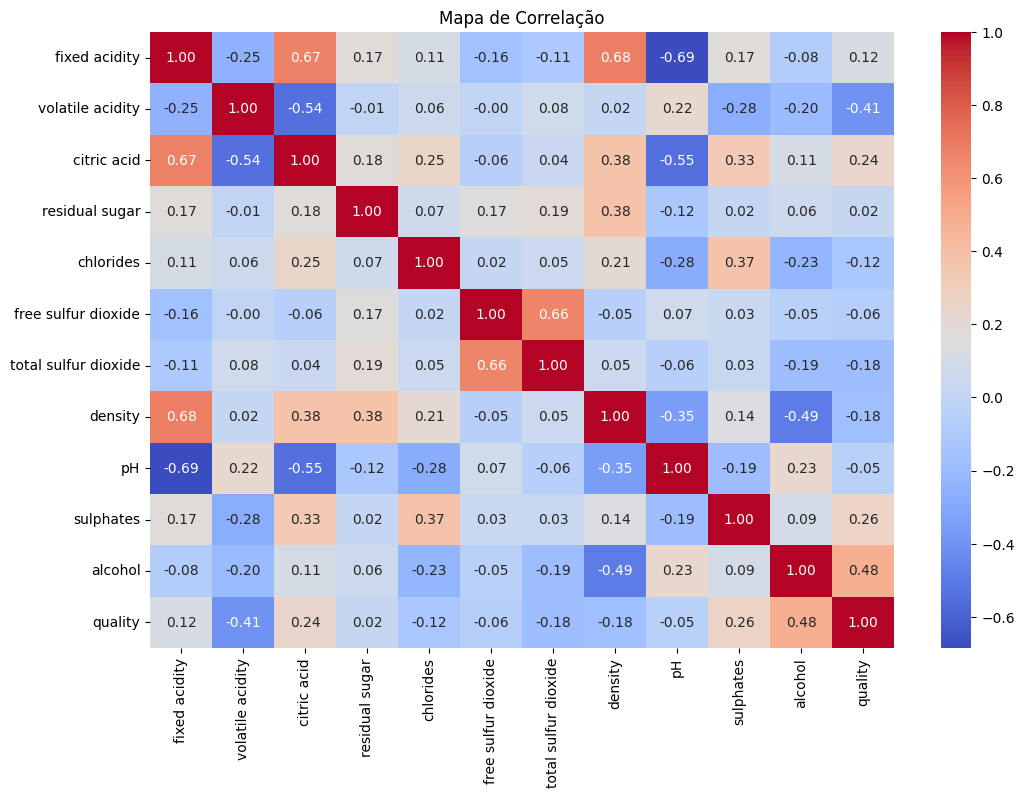

In [86]:
# Cole o código do wine_quality_fuzzy_real.py
sommelier = SommelierFuzzy()
data = sommelier.carregar_dataset()

# ATIVIDADE: Explore os dados
print("🔍 MISSÃO: Descubram padrões interessantes!")
sommelier.analise_exploratoria()

### Sobre o gráfico de correlação

In [48]:
# Ajuda a decidir quais colunas fazem sentido pra lógica fuzzy, e quais são ruído puro.

### Cosntruindo o sistema fuzzy

#### Avaliando com tres entradas e uma saída (quality)

In [91]:
#  Avaliação de vinhos com o sistema fuzzy

# sommelier.avaliar_vinho(alcool_val=13.5, sulphates_val=1.5, vol_acidity_val=0.2)
# sommelier.avaliar_vinho(13.5, 1.5, 0.2)
# sommelier = SommelierFuzzy()
# sommelier.carregar_dataset()

resposta1 = sommelier.avaliar_por_correlacao(13.5, 1.5, 0.2)
print(resposta1)

# resposta2 = sommelier.avaliar_por_correlacao(11, 0.7, 0.5)
# print(resposta2)

# sommelier.avaliar_vinho(alcool_val=12.5, sulphates_val=1.1, vol_acidity_val=0.3)
# sommelier.avaliar_vinho(12.5, 1.1, 0.3)

# sommelier.avaliar_vinho(alcool_val=11, sulphates_val=0.7, vol_acidity_val=0.5)
# sommelier.avaliar_vinho(11, 0.7, 0.5)

🍷 Este vinho promete! Teor alcoólico elevado, bom nível de sulphates e baixa acidez volátil. Tá digno de uma celebração.
